# WGBS simulations 

## Imports and Setup 

In [1]:
import numpy as np 
import pandas as pd 
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import stats
import os
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc

In [2]:
sns.set(context='talk', style='white', rc={'figure.facecolor':'white'}, font_scale=1)
sns.set_style('ticks')
os.chdir("/Users/christacaggiano/Desktop/zaitlen_lab_desktop/")

## Data Functions

In [3]:
def calculate_correlation(true, est, tissue, method, replicate, output):
    
    for t in range(est.shape[0]): 
        corr = np.corrcoef(est[t, :], true[t, :])[0][1]  # calculate the correlation between the true/est tissue
            
        if method == "gamma_corr": 
            output.append([corr, tissue[t]])

        if method == "alpha_corr":    
            output.append([corr, t, replicate])

    return output

In [54]:
def load_estimates(est, true, tissue, replicate, output):
    
    np.random.seed(6)  # set random seed so that the random person is same everytime 
    rint = np.random.randint(est.shape[0]) # select random person 

    e, t = est[rint, :], true[rint, :]  # randomly selected person 

    for i in range(len(t)):  # add each estimate for each tissue to dataframe 
        output.append([e[i], t[i], tissue[i], replicate])
    
    return output 
        

In [55]:
def switch_unknowns(estimate, gamma_true, gamma_est):
    
    unk1_corr = np.corrcoef(gamma_est[unk1, :], gamma_true[unk1, :])[0][1] < np.corrcoef(gamma_est[unk1, :], gamma_true[unk2, :])[0][1]
    unk2_corr = np.corrcoef(gamma_est[unk2, :], gamma_true[unk2, :])[0][1] < np.corrcoef(gamma_est[unk2, :], gamma_true[unk1, :])[0][1]
      
    if unk1_corr and unk2_corr:  
        unk1_est = estimate[unk1, :].copy()
        unk2_est = estimate[unk2, :].copy()

        estimate[unk1, :] = unk2_est
        estimate[unk2, :] = unk1_est
        
    return estimate

In [56]:
def call_selected_method(method, gamma_true, gamma_est, true, est, tissue, file, output): 
    
    if method == "gamma_corr": 
        output =  calculate_correlation(gamma_true, gamma_est, tissue, method, file, output)

    if method == "alpha_corr": 
        output =  calculate_correlation(true, est, tissue, method, file, output)
    
    if method == "estimate":
        output =  load_estimates(est, true, tissue, file, output) 
        
    return output 

In [57]:
def load_pickles(directory, unk1, unk2, tissue, method):
    """
    output from EM is a pickle file of estimate and true simulation values 
    load these pickles into dataframe 
    """
    est_files = glob.glob(directory + "/*alpha_est.pkl")  # estimates from EM 
    
    est_file = est_files[0]
    true_file = est_file.replace("est", "true")
    
    gamma_est_file = est_file.replace("alpha", "gamma")  # find the gamma files as well 
    true_gamma_file  = gamma_est_file.replace("est", "true")
        
    true = pkl.load(open(true_file, "rb"))
    est = pkl.load(open(est_file, "rb"))
    
    gamma_true = pkl.load(open(true_gamma_file, "rb"))
    gamma_est = pkl.load(open(gamma_est_file, "rb"))
    
    gamma_est = switch_unknowns(gamma_est, gamma_true, gamma_est)
    est = switch_unknowns(est, gamma_true, gamma_est)
    
    est_avg = gamma_est
    output = [] 
    
    if method is not "average": 
        output = call_selected_method(method, gamma_true, gamma_est, true, est, tissue, 0, output) 

    for file in range(1, len(est_files)):  # iterate over all random restarts in the directory 
        
        est_file = est_files[file]        
        est = pkl.load(open(est_file, "rb"))
        
        gamma_est_file = est_file.replace("alpha", "gamma")
        gamma_est = pkl.load(open(gamma_est_file, "rb"))
        
        gamma_est = switch_unknowns(gamma_est, gamma_true, gamma_est)
        est = switch_unknowns(est, gamma_true, gamma_est)
        
        if method is not "average": 
            output = call_selected_method(method, gamma_true, gamma_est, true, est, tissue, file, output) 
        
        if method == "average": 
            est_avg += gamma_est
        
                   
    if method == "gamma_corr": 
        return pd.DataFrame(output, columns=["correlation", "tissue"])
        
    if method == "alpha_corr": 
        return pd.DataFrame(output, columns=["correlation", "person", "replicate"])
    
    if method == "estimate": 
        return pd.DataFrame(output, columns=["estimate", "truth", "tissue", "replicate"])
        
    if method == "average": 
        est_avg = est_avg/len(est_files)
        return (pd.DataFrame(est_avg.T, columns=tissue), pd.DataFrame(gamma_true.T, columns=tissue))



## Load Data 

In [58]:
# labels for the tissues 
tissue_labels = ["small intestine", "pancreas", "stomach ", "tibial" , 
                 "adipose", "neutrophil", "tcell", "macrophage", "memory b cell", "monocyte"]

In [59]:
#  set which tissues were the unknowns when celfie was run 
unk1 = 0 
unk2 = 6

### 2 unknowns 

In [64]:
directory = "/Users/christacaggiano/Desktop/zaitlen_lab_desktop/wgbs_unk2_0201_100_06_3/"
unk2_estimates = load_pickles(directory, unk1, unk2, tissue_labels, "estimate")
unk2_gamma_corr = load_pickles(directory, unk1, unk2, tissue_labels, "gamma_corr")
unk2_alpha_corr = load_pickles(directory, unk1, unk2, tissue_labels, "alpha_corr")

In [65]:
print("gamma correlation", unk2_gamma_corr["correlation"].mean()) 
print("alpha correlation", unk2_alpha_corr["correlation"].mean()) 

gamma correlation 0.9508738445959184
alpha correlation 0.599503119999237


### 1 unknown 

In [66]:
directory = "/Users/christacaggiano/Desktop/zaitlen_lab_desktop/wgbs_unk1_0201_100_06/"
unk1_estimates = load_pickles(directory, unk1, unk2, tissue_labels, "estimate")
unk1_gamma_corr = load_pickles(directory, unk1, unk2, tissue_labels, "gamma_corr")
unk1_alpha_corr = load_pickles(directory, unk1, unk2, tissue_labels, "alpha_corr")

In [67]:
print("gamma correlation", unk1_gamma_corr["correlation"].mean()) 
print("alpha correlation", unk1_alpha_corr["correlation"].mean()) 

gamma correlation 0.9605922759940043
alpha correlation 0.8227744049128479


### No unknowns

In [68]:
directory = "/Users/christacaggiano/Desktop/zaitlen_lab_desktop/wgbs_unk0_0201_100_06/"
unk0_estimates = load_pickles(directory, unk1, unk2, tissue_labels, "estimate")
unk0_gamma_corr = load_pickles(directory, unk1, unk2, tissue_labels, "gamma_corr")
unk0_alpha_corr = load_pickles(directory, unk1, unk2, tissue_labels, "alpha_corr")

In [69]:
print("gamma correlation", unk0_gamma_corr["correlation"].mean()) 
print("alpha correlation", unk0_alpha_corr["correlation"].mean()) 

gamma correlation 0.9612799876135775
alpha correlation 0.8256251572902525


## Plot 

In [70]:
# order the tissues by ascending true value for aesthetically pleasing plots 
tissue_order = list(unk0_estimates[unk0_estimates.replicate == 1 ].sort_values(by=["truth"])["tissue"])
true_values = list(unk0_estimates[unk0_estimates.replicate == 1 ].sort_values(by=["truth"])["truth"])

### Plot CelFiE etimates 

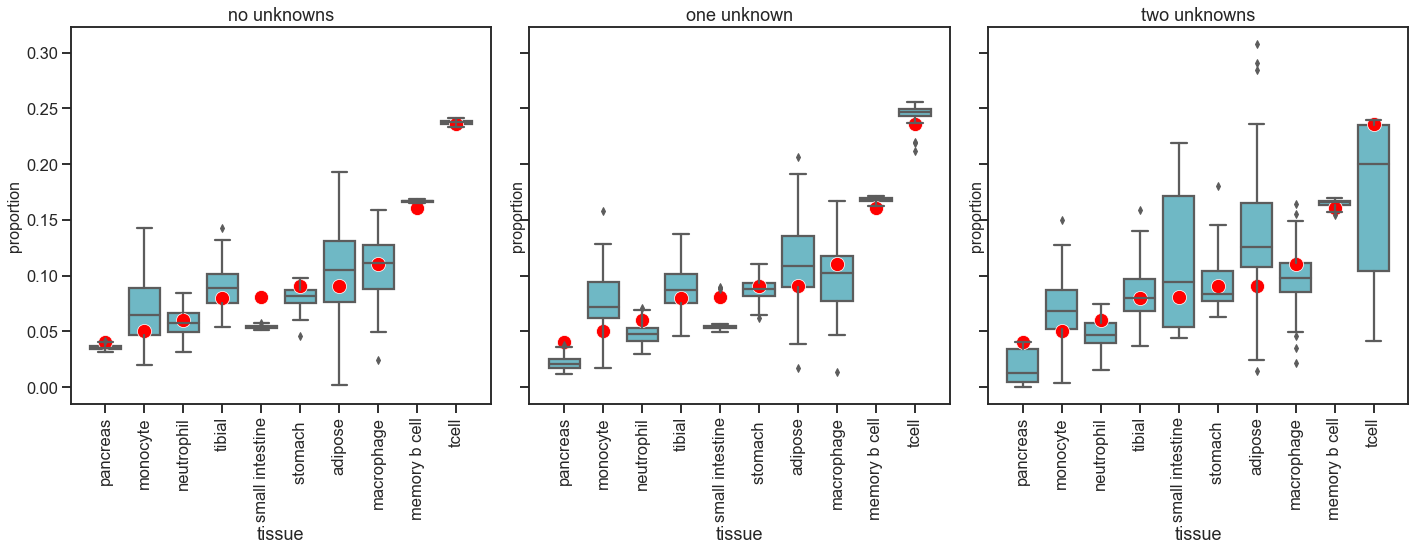

In [71]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(20,8))

sns.set_context("talk")

sns.boxplot("tissue", "estimate", order=tissue_order, data = unk2_estimates, color="#61c2d3", ax=ax3)
sns.scatterplot(tissue_order, true_values, color="red", s=200, ax=ax3)

sns.boxplot("tissue", "estimate", data = unk1_estimates, order=tissue_order, color="#61c2d3", ax=ax2)
sns.scatterplot(tissue_order, true_values, color="red", s=200, ax=ax2)

sns.boxplot("tissue", "estimate", data = unk0_estimates, order=tissue_order, color="#61c2d3", ax=ax1)
sns.scatterplot(tissue_order, true_values, color="red", s=200, ax=ax1)

for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)

for tick in ax3.get_xticklabels():
    tick.set_rotation(90)
    
ax1.set_ylabel("proportion", fontsize=16)
ax2.set_ylabel("proportion", fontsize=16)
ax3.set_ylabel("proportion", fontsize=16)

ax1.set_title("no unknowns")
ax2.set_title("one unknown")
ax3.set_title("two unknowns")


fig.tight_layout()


### Plot gamma correlation 

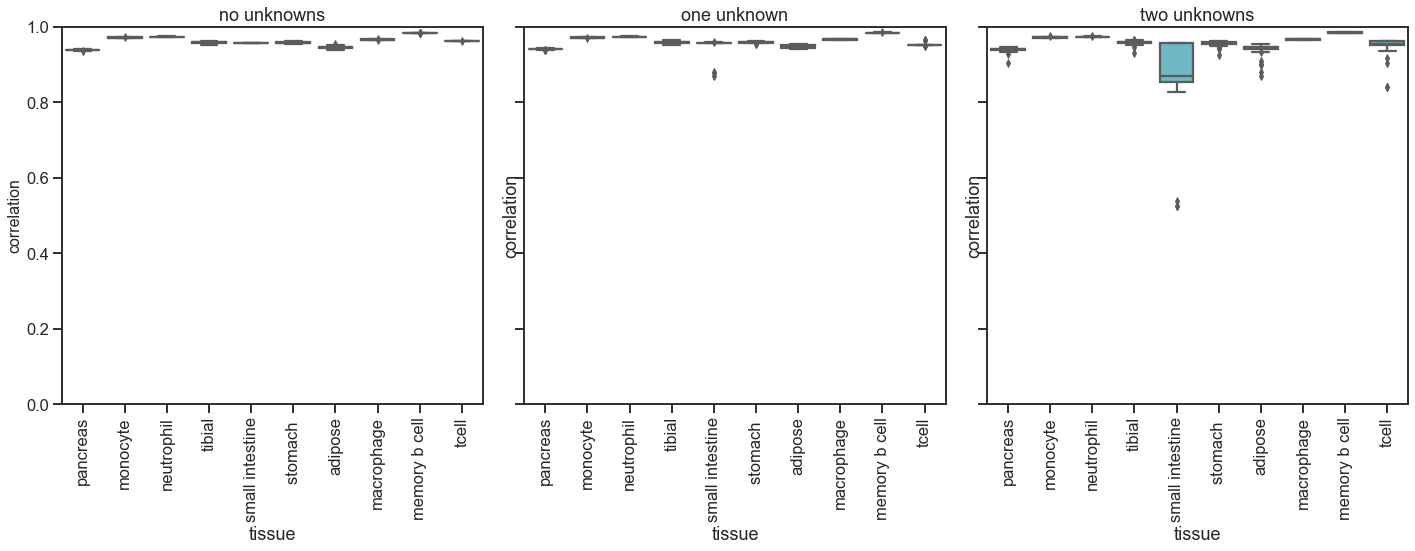

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(20,8))

sns.set_context("talk")

sns.boxplot("tissue", "correlation", data = unk2_gamma_corr, order=tissue_order, color="#61c2d3", ax=ax3)
sns.boxplot("tissue", "correlation", data = unk1_gamma_corr, order=tissue_order, color="#61c2d3", ax=ax2)
sns.boxplot("tissue", "correlation", data = unk0_gamma_corr, order=tissue_order, color="#61c2d3", ax=ax1)

for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)

for tick in ax3.get_xticklabels():
    tick.set_rotation(90)
    
ax1.set_ylabel("correlation", fontsize=16)
ax1.set_ylim(0, 1)

ax1.set_title("no unknowns")
ax2.set_title("one unknown")
ax3.set_title("two unknowns")


fig.tight_layout()


### Plot pairwise correlation 

#### 2 unknowns

In [19]:
# calculate the average gamma estimate across all replicates for 2 unknowns 
directory = "/Users/christacaggiano/Desktop/zaitlen_lab_desktop/wgbs_unk2_0201_100_06_3/"
unk2_gamma_avg, unk2_gamma_true = load_pickles(directory, unk1, unk2, tissue_labels, "average")

In [20]:
# append the estimated small intestine and t-cell gammas to the true matrix 
unk2_gamma_true["unknown small intestine"] = unk2_gamma_avg["small intestine"]
unk2_gamma_true["unknown t cell"] = unk2_gamma_avg["tcell"]

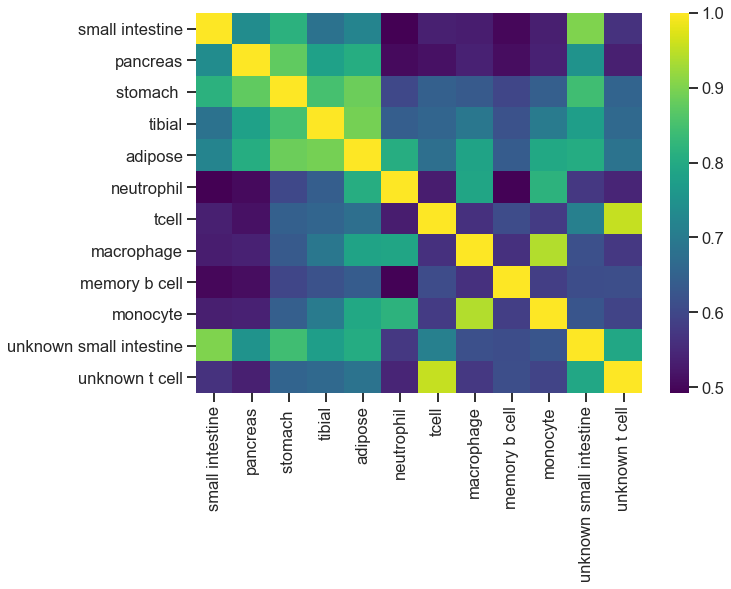

In [22]:
# plot pairwise correlation between all tissues + unknowns in the reference 
plt.figure(figsize=(10, 7))  
sns.heatmap(unk2_gamma_true.corr(), cmap="viridis")
plt.show()

#### 1 unknown 

In [23]:
# calculate the average gamma estimate across all replicates for 1 unknowns 
directory = "/Users/christacaggiano/Desktop/zaitlen_lab_desktop/wgbs_unk1_0201_100_06_3/"
unk1_gamma_avg, unk1_gamma_true = load_pickles(directory, unk1, unk2, tissue_labels, "average")

In [24]:
unk1_gamma_true["unknown t cell"] = unk1_gamma_avg["tcell"]

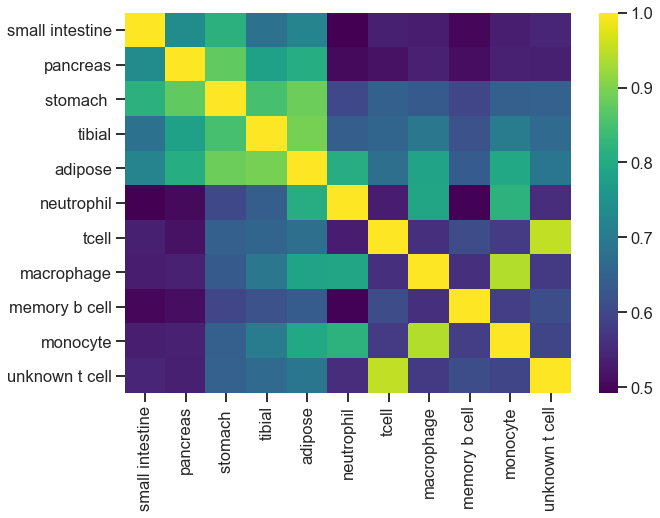

In [26]:
# plot pairwise correlation between all tissues + 1 unknown in the reference 
plt.figure(figsize=(10, 7))  
sns.heatmap(unk1_gamma_true.corr(), cmap="viridis")
plt.show()

### Hierarchical clustering 

#### 2 unknowns

In [76]:
unk2_scaled = normalize(unk2_gamma_true)
unk2_scaled = pd.DataFrame(unk2_scaled, columns=unk2_gamma_true.columns)
unk2_scaled = unk2_scaled.values.T 

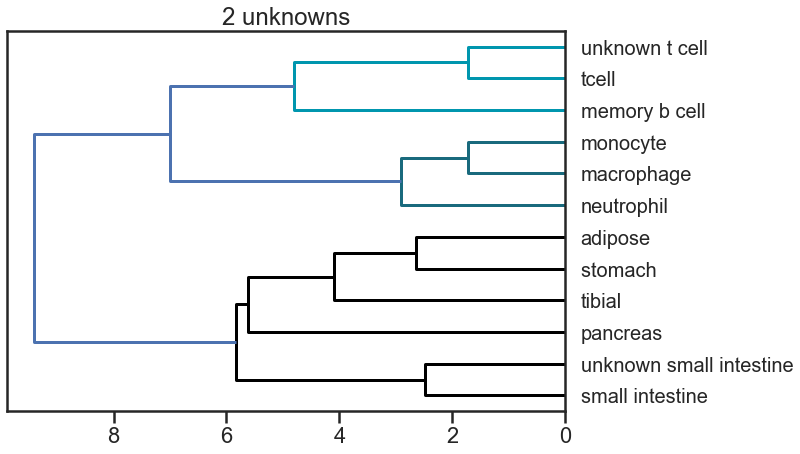

In [77]:
sns.set_context("poster")
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
shc.set_link_color_palette(['black', '#196a7d', '#0096ae', '#61c2d3'])
dend = shc.dendrogram(shc.linkage(unk2_scaled, method='ward'), orientation='left', 
                      labels=unk2_gamma_true.columns, leaf_font_size = 20)
plt.title("2 unknowns")
plt.show()

#### 1 unknown

In [78]:
unk1_scaled = normalize(unk1_gamma_true)
unk1_scaled = pd.DataFrame(unk1_scaled, columns=unk1_gamma_true.columns)
unk1_scaled = unk1_scaled.values.T 

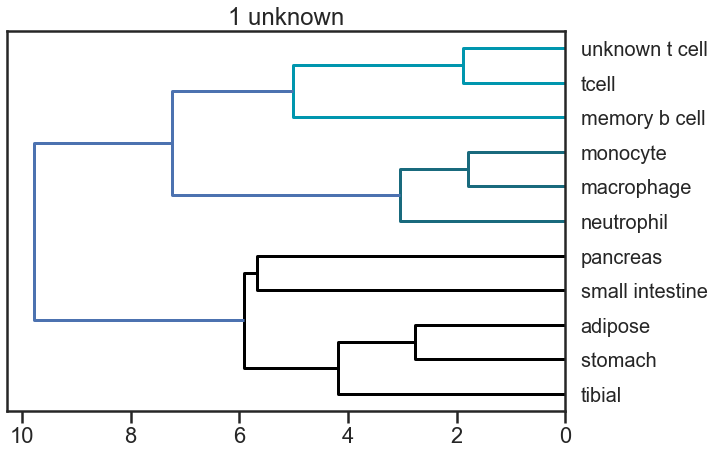

In [79]:
sns.set_context("poster")
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
shc.set_link_color_palette(['black', '#196a7d', '#0096ae', '#61c2d3'])
dend = shc.dendrogram(shc.linkage(unk1_scaled, method='ward'), orientation='left', 
                      labels=unk1_gamma_true.columns, leaf_font_size = 20)
plt.title("1 unknown")
plt.show()